In [3]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [4]:
import os
import pickle5 as pickle

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc

from benchmark.eval import aggreg_seed_results

from tueplots import axes as tue_axes
from tueplots import cycler as tue_cycler
from tueplots.constants.color import palettes as tue_palettes

sc.set_figure_params(vector_friendly=True, dpi_save=300)

# Configure the plots.
plt.rcParams.update({"figure.dpi": 80})
plt.rcParams.update(tue_axes.spines(left=True, right=False, top=False, bottom=True))
plt.rcParams.update(tue_axes.grid())
plt.rcParams.update(tue_cycler.cycler(color=tue_palettes.high_contrast))
plt.rcParams.update(tue_axes.legend(shadow=False, frameon=False, fancybox=False))

ctp_colors = {"HCT": "blue", "K562": "yellow", "Hela": "red"}

/Users/jsamaran/miniconda3/envs/mui/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jsamaran/miniconda3/envs/mui/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <9A4710B9-0DA3-36BB-9129-645F282E64B2> /Users/jsamaran/miniconda3/envs/mui/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <1E9FA061-EA31-3736-81D0-79A33B965097> /Users/jsamaran/miniconda3/envs/mui/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/jsamaran/miniconda3/envs/mui/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils

In [7]:
save_path = "./saved_cline_figures"
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [8]:
results = pickle.load(open("exp_results/cline_rez.pickle", "rb"))

/var/folders/1k/ggmt2mb53m320bxwd70cn3wc69xyl8/T/ipykernel_4520/2295167255.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='exp_results/cline_rez.pickle'>
  results = pickle.load(open("exp_results/cline_rez.pickle", "rb"))


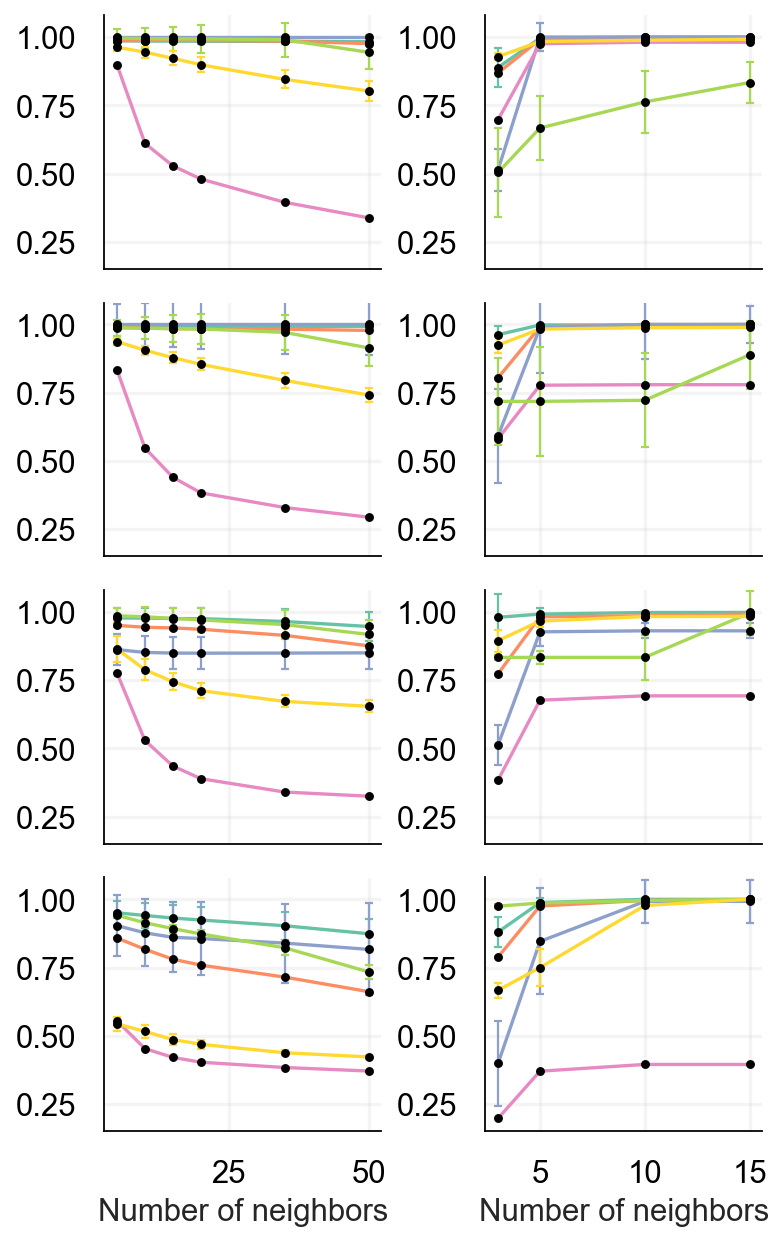

In [10]:
metrics_to_plot = ['purity', 'graph_connectivity']
method_names = list(results["normal"].keys())
k_arrays = [[5, 10, 15, 20, 35, 50], [3, 5, 10, 15]]
fig, axes = plt.subplots(len(results), 2, figsize=(5, 8))
palette = sns.color_palette("Set2", n_colors=7)
colors = {meth_name: palette[k] for k, meth_name in enumerate(method_names)} 
for i, (ds_name, ds_results) in enumerate(results.items()):
    median_res, std_res = aggreg_seed_results(ds_results, metrics=metrics_to_plot)
    for j, metric in enumerate(metrics_to_plot):
        for method_name, color in colors.items():
            axes[i, j].plot(k_arrays[j], median_res[method_name][metric], c=color, label=method_name)
            axes[i, j].errorbar(k_arrays[j], median_res[method_name][metric], 
                             yerr=std_res[method_name][metric],
                             fmt="o", color='black', ecolor=color, elinewidth=1, capsize=2, ms=3)
        axes[i, j].set_ylim(0.15, 1.08)
        if i != len(results) - 1:
            axes[i, j].xaxis.set_ticklabels([])
axes[-1, 0].set_xlabel("Number of neighbors")
axes[-1, 1].set_xlabel("Number of neighbors")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "rez.pdf"))

# Plotting UMAPS

In [11]:
def plot_cline_umaps(adatas, method_names, colors, markers, s=15, n_neigh=20, plot_meth="us", save_path=None, 
                     fontsize=10, alpha=0.7, figsize=(13, 10)):
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    axes = fig.subplots(len(adatas), len(method_names))
    if len(adatas) == 1:
        axes = axes[np.newaxis, :]
    for i, adata in enumerate(adatas.values()):
        for j, method in enumerate(method_names):
            adata.uns = {}
            sc.pp.neighbors(adata, use_rep="latents_{}".format(method), n_neighbors=n_neigh)
            sc.tl.umap(adata)
            plot_one_umap(adata, colors, markers, s=s, ax=axes[i, j], plot_meth=plot_meth, alpha=alpha)
    for k, method in enumerate(method_names): 
        axes[0, k].set_title(method, fontsize=fontsize)
    for i in range(len(adatas)):
        for j in range(len(method_names)):
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)

    
def plot_one_umap(adata, colors, markers, s, ax, plot_meth, alpha):
    if plot_meth == "us":
        for ctype, col in colors.items():
            for mod, mark in markers.items():
                mask = np.logical_and((adata.obs["celltype"] == ctype).values, (adata.obs["modality"] == mod).values)
                if mark == "empty_circle":
                    ax.scatter(adata.obsm["X_umap"][mask][:, 0], adata.obsm["X_umap"][mask][:, 1], 
                               edgecolors=np.array(col)/255, facecolors="none", 
                               rasterized=True, alpha=alpha)
                else:
                    ax.scatter(adata.obsm["X_umap"][mask][:, 0], adata.obsm["X_umap"][mask][:, 1], 
                               color=np.array(col)/255, marker=mark, rasterized=True, alpha=alpha)
    else:
        sc.pl.umap(adata, ax=ax, color="celltype", s=s, alpha=alpha, title="", show=False)
        ax.get_legend().remove()
    ax.set_facecolor((0, 0, 0, 0))

In [16]:
with open("exp_results/cline_rez_adatas.pickle", "rb") as f:
    adatas = pickle.load(f)

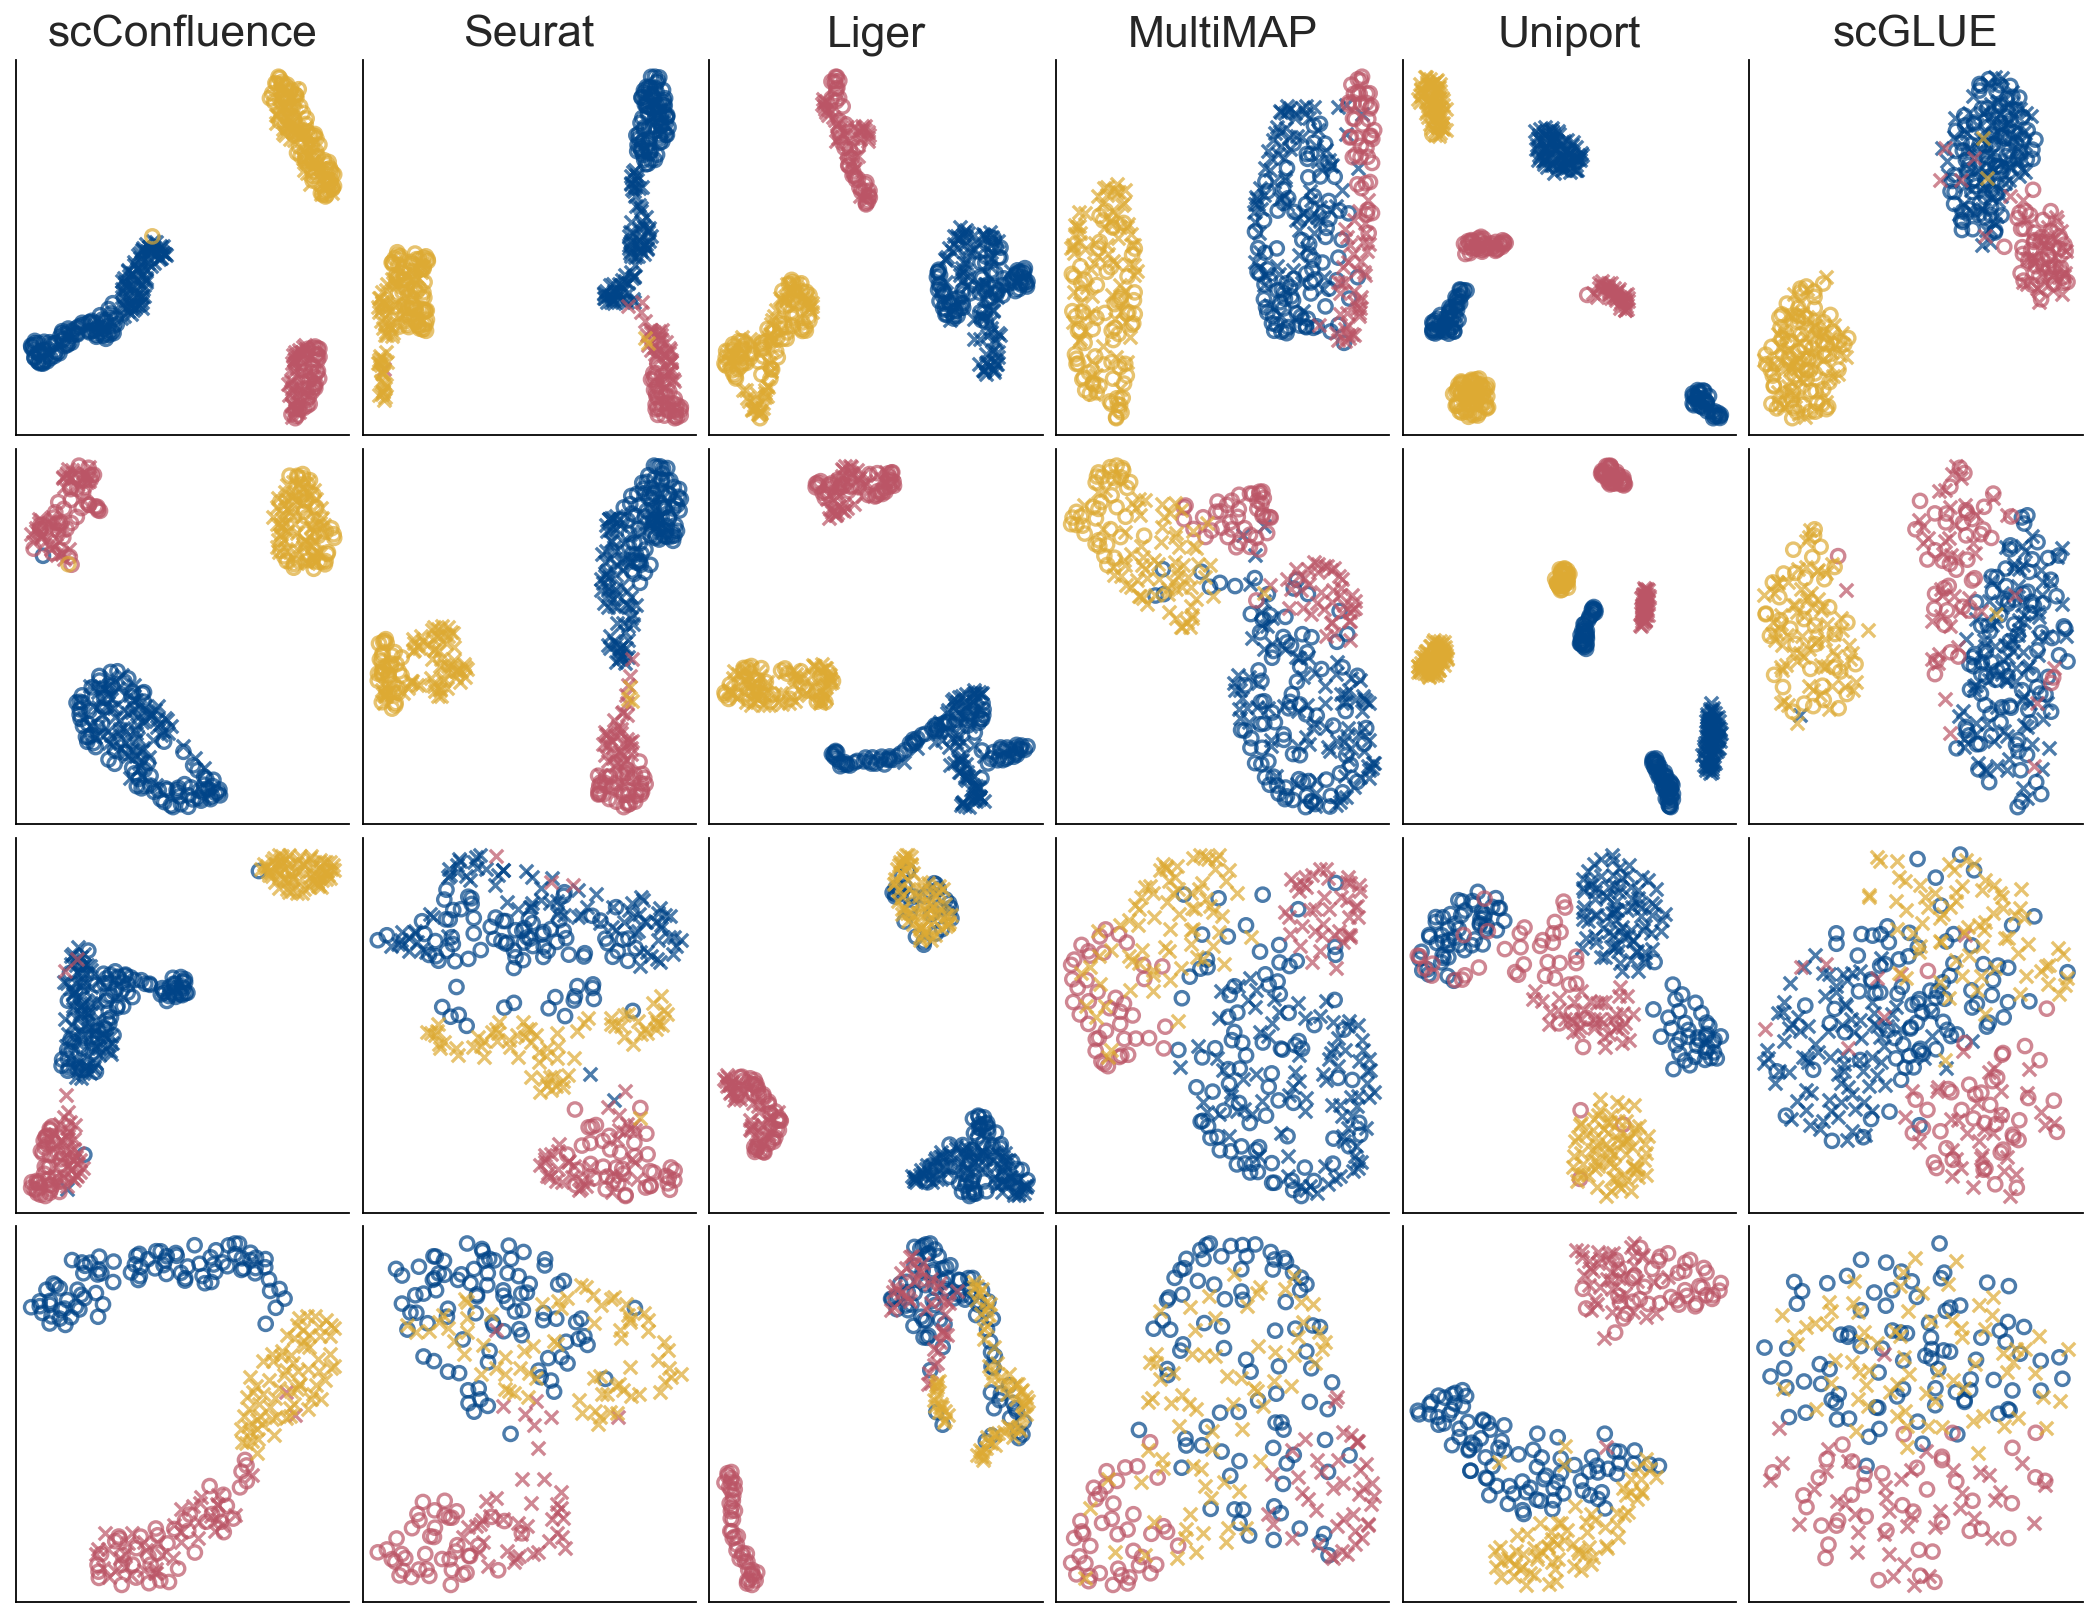

In [17]:
colors = {"HCT": [0, 68, 136], "Hela": [187,85,102], "K562": [221, 170, 51]}
markers = {"GEX": "empty_circle", "ATAC": "x"}
plot_cline_umaps(adatas, colors=colors, markers=markers, 
                 method_names=["scConfluence", "Seurat", "Liger", "MultiMAP", "Uniport", "scGLUE"], s=8, n_neigh=20, 
                 plot_meth="us", save_path=os.path.join(save_path, "umap_grid.pdf"), alpha=0.7, fontsize=20)

# Liger supplementary UMAP

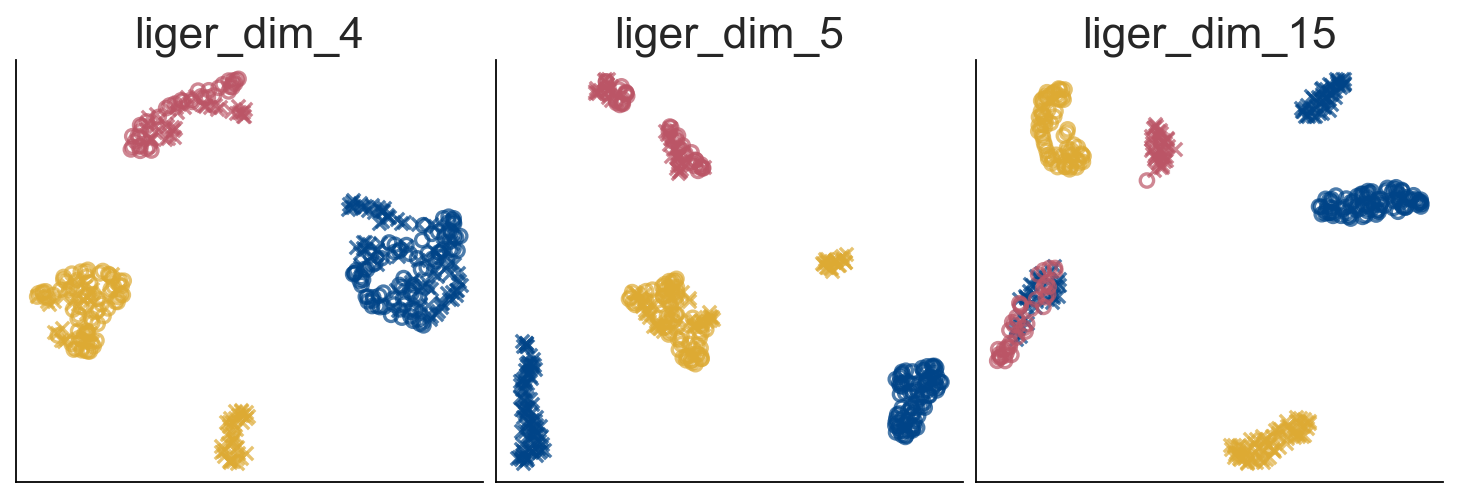

In [19]:
colors = {"HCT": [0, 68, 136], "Hela": [187,85,102], "K562": [221, 170, 51]}
markers = {"GEX": "empty_circle", "ATAC": "x"}
plot_cline_umaps(adatas={"normal": adatas["normal"]}, colors=colors, markers=markers, 
                 method_names=[f"liger_dim_{nz}" for nz in [4, 5, 15]], s=8, n_neigh=20, 
                 plot_meth="us", save_path=os.path.join(save_path, "supp_liger.pdf"), alpha=0.7, fontsize=20, 
                 figsize=(9, 3))